# WWTP inflow dataset: Horsens

In [2]:
import json
import folium

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import abspath
from IPython.display import display, HTML
from scipy.optimize import minimize_scalar

from darts import TimeSeries
from darts.utils.statistics import extract_trend_and_seasonality, ModelMode
from darts.utils.missing_values import fill_missing_values, extract_subseries

In [3]:
# Define the coordinates for Horsens Municipality
horsens_coords = [55.8607, 9.8502]  # Approximate center of Horsens Municipality
dmi_station_coords = [55.868, 9.7872]
wwtp_coords = [55.85512, 9.85414]

m = folium.Map(location=horsens_coords, zoom_start=12)

folium.Marker(
    dmi_station_coords,
    popup="weather station",
    tooltip="DMI station",
    icon=folium.Icon(icon="cloud", color="green"),
).add_to(m)
folium.Marker([55.8540, 9.8600], popup="WWTP", tooltip="WWTP").add_to(m)

display(
    HTML(
        """
    <div style="width: 50%; height: 50%; margin: auto;">
        """
        + m._repr_html_()
        + """
    </div>
"""
    )
)

## Loading data

In [4]:
path_to_inflow = "../observations/wwtp.csv"
path_to_dmi_data = "../observations/dmi.csv"

# Inflow measuring unit is m3/h
inflow = pd.read_csv(abspath(path_to_inflow), parse_dates=True, index_col=0, sep=";")
inflow.index.name = "time"
inflow.index = inflow.index.tz_localize(
    "Europe/Copenhagen", ambiguous="NaT"
).tz_convert("utc")

DMI always provides data in UTC (https://opendatadocs.dmi.govcloud.dk/en/Data/Climate_Data)

In [ ]:
climate = pd.read_csv(abspath(path_to_dmi_data), parse_dates=True, index_col=0, sep=",")
climate.index = climate.index.tz_localize("utc")

In [ ]:
horsens = inflow.merge(climate, left_index=True, right_index=True, how="outer").iloc[
    :-1
]

,FB20F11_81,acc_precip,mean_pressure,mean_radiation,mean_relative_hum,mean_temp,temp_grass,temp_soil_10,temp_soil_30
time,,,,,,,,,
2025-02-17 20:00:00+00:00,1210.139000,0.0,1026.9,0.0,77.2,-4.0,NaN,NaN,NaN
2025-02-17 21:00:00+00:00,1130.599583,0.0,1027.0,0.0,80.0,-4.5,NaN,NaN,NaN
2025-02-17 22:00:00+00:00,1131.153500,0.0,1027.2,0.0,81.2,-4.7,NaN,NaN,NaN
2025-02-17 23:00:00+00:00,1708.180000,0.0,1027.6,0.0,82.2,-5.1,NaN,NaN,NaN
2025-02-18 00:00:00+00:00,NaN,0.0,1027.9,0.0,81.7,-5.0,NaN,NaN,NaN


## Gaps

There are some instances of measureming a flow that is exactly 0, I count that as nan. Similarly, values that are very close are also counted as nan.

In [ ]:
threshold_flow = 2  # There are values that are very close to zer
horsens[horsens["FB20F11_81"] < threshold_flow] = np.nan

Also, there are periods that are a flat line, we consider those nans as well

In [ ]:
def find_flat_periods(series: pd.Series, min_span_length: int, min_delta: float):
    """
    Find periods where the value of the series does not change at least `min_delta` within `min_span_length` steps.

    Returns:
    List of tuples: Each tuple contains the start and end index of a stable period.
    """
    stable_periods = []
    start_idx = None

    for i in range(len(series) - 1):
        if abs(series.iloc[i + 1] - series.iloc[i]) < min_delta:
            if start_idx is None:
                start_idx = i
        else:
            if start_idx is not None and i - start_idx > min_span_length:
                stable_periods.append((start_idx, i - 1))
            start_idx = None

    # Capture any ongoing stable period at the end
    if start_idx is not None:
        stable_periods.append((start_idx, len(series) - 1))

    return stable_periods


period_length = 6  # hours
min_delta = 5  # flow
stable_periods = find_flat_periods(
    horsens["FB20F11_81"], min_span_length=period_length, min_delta=min_delta
)
stable_idx = [l for idx in stable_periods for l in list(range(*idx))]

horsens.loc[horsens.index[stable_idx], "FB20F11_81"] = np.nan

In [ ]:
ts = TimeSeries.from_dataframe(horsens, freq="h", fill_missing_dates=False)
ts = fill_missing_values(ts, method="linear", limit=3, limit_area="inside")

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


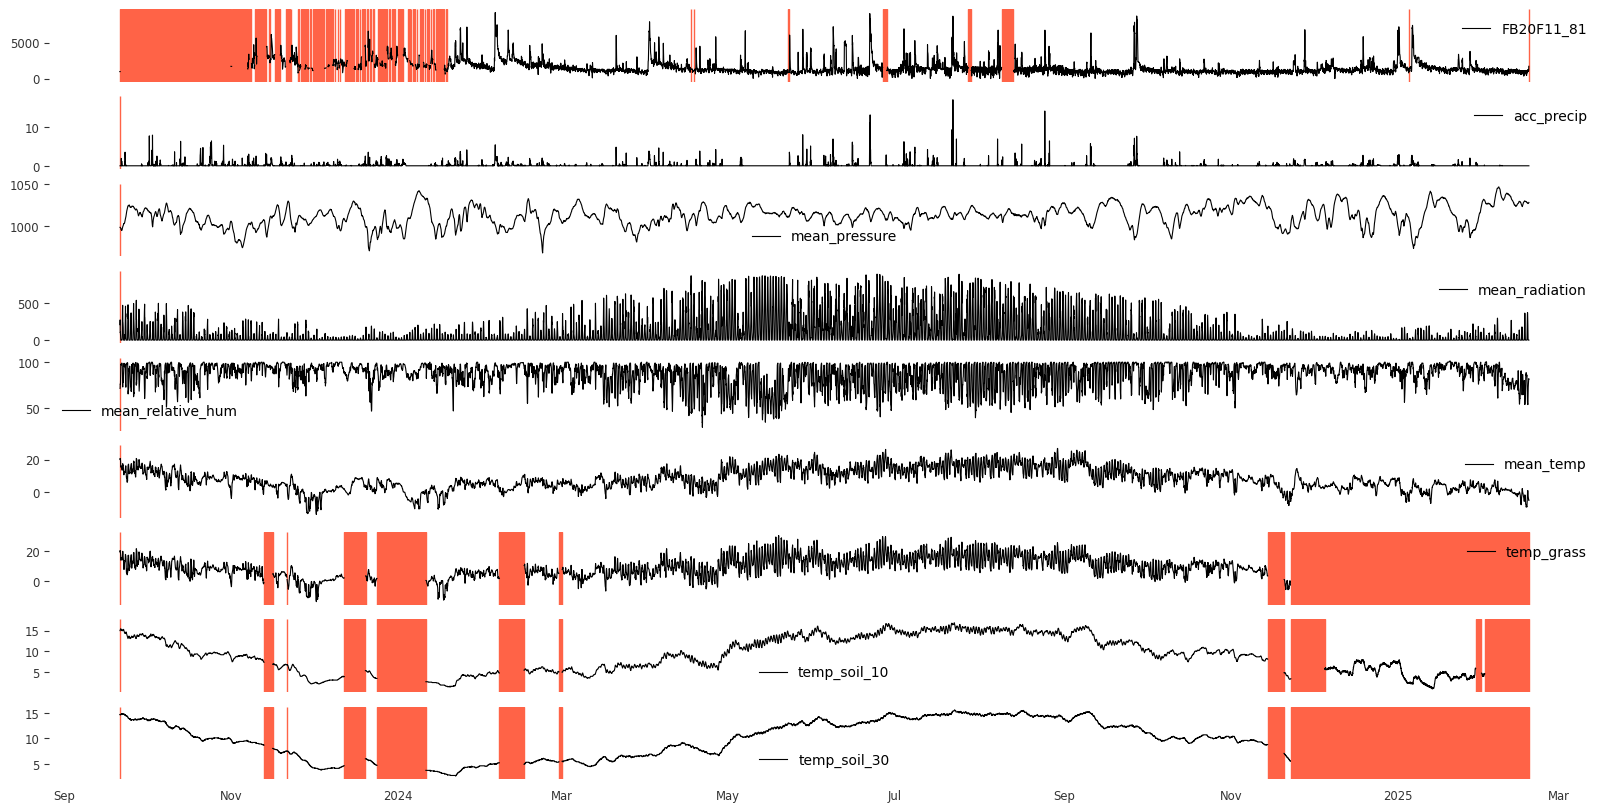

In [ ]:
fig, axes = plt.subplots(ts.n_components, 1, figsize=(20, 10), sharex="col")

for i, component in enumerate(ts.components):
    gaps = ts[component].gaps(mode="any")
    ts[component].plot(ax=axes[i], linewidth=0.8)
    for _, row in gaps.iterrows():
        axes[i].axvspan(xmin=row["gap_start"], xmax=row["gap_end"], color="tomato")
    axes[i].grid(visible=False)
    axes[i].set_xlabel("")

In [ ]:
ts.to_csv("../processed/data.csv")

## Daily trend

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.
The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.
The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the 

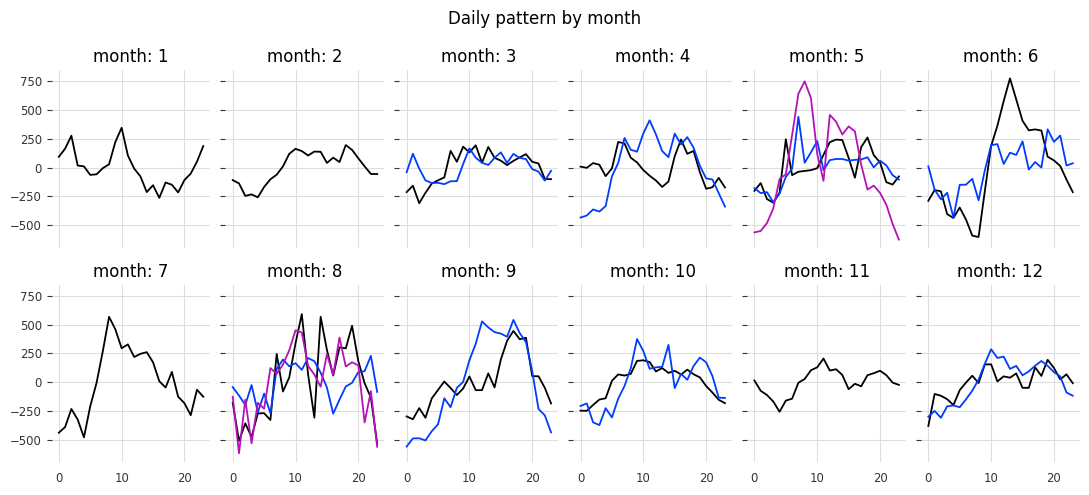

In [ ]:
df = horsens[["FB20F11_81"]].copy()
df = df.loc[df.index.year == 2024, :].copy()

ncols = 6
fig, axes = plt.subplots(2, ncols, sharex=True, sharey=True, figsize=(11, 5))

month = 1
for i, month in enumerate(range(1, 13)):
    df_i = df.loc[df.index.month == month, :]
    df_i.index.tz = None  # this is done to avoid a warning message from darts
    ts_i = TimeSeries.from_dataframe(df_i, freq="h")
    subseries = extract_subseries(ts_i)
    for ssi in subseries:
        if len(ssi) > 72:
            trend_i, seasonality_i = extract_trend_and_seasonality(
                ssi, freq=24, model=ModelMode.ADDITIVE
            )
            daily_pattern = (
                seasonality_i.pd_dataframe()
                .groupby(seasonality_i.time_index.hour)
                .mean()
            )

            row = i // ncols
            col = i - row * ncols
            axes[row, col].plot(daily_pattern.index, daily_pattern.values.ravel())
            axes[row, col].set_title(f"month: {month}")

plt.suptitle("Daily pattern by month")
plt.tight_layout()

## Correlations

In [10]:
def lp_filter(x: np.array, alpha: float) -> np.array:
    # https://empslocal.ex.ac.uk/people/staff/dbs202/cag/courses/MT37C/course/node102.html
    y = np.zeros_like(x)
    y[0] = x[0]

    for t in range(1, len(x)):
        y[t] = alpha * x[t] + (1 - alpha) * y[t - 1]

    return y

In [ ]:
def f(x: float, ts: TimeSeries, lag: int):
    time_index = ts.time_index
    filtered_precip = pd.Series(
        lp_filter(ts["acc_precip"].values().ravel(), x), index=time_index
    )
    x1 = filtered_precip.shift(lag).dropna()
    x2 = ts["FB20F11_81"].pd_series().loc[x1.index]

    return -np.abs(np.corrcoef(x1.values, x2.values)[0, 1])


ts = TimeSeries.from_dataframe(
    horsens[["FB20F11_81", "acc_precip"]].apply(np.log1p), freq="h"
).longest_contiguous_slice(mode="any")


for lag in [0, 1, 2, 3, 4]:
    res = minimize_scalar(f, bounds=(1e-5, 0.9999), args=(ts, lag))
    print(lag, round(res.fun, 3), round(res.x, 3))

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


0 -0.79 0.019
1 -0.768 0.018
2 -0.745 0.017
3 -0.724 0.016
4 -0.704 0.016


<Axes: xlabel='time'>

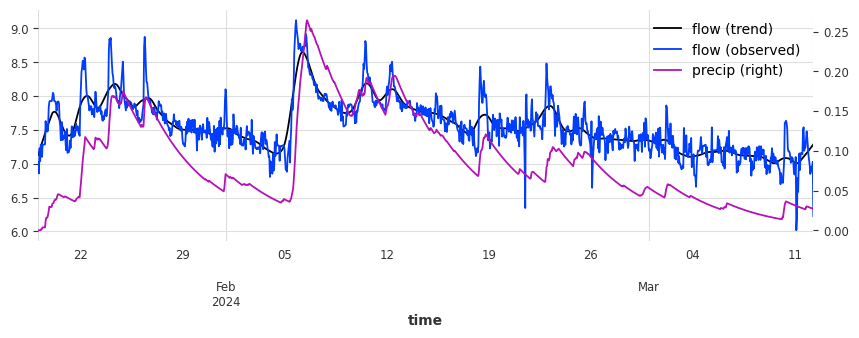

In [12]:
trend, seasonality = extract_trend_and_seasonality(
    ts["FB20F11_81"], model=ModelMode.ADDITIVE, method="STL"
)

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
pd.DataFrame(
    {
        "flow (trend)": trend.values().ravel(),
        "flow (observed)": ts["FB20F11_81"].values().ravel(),
        "precip": lp_filter(ts["acc_precip"].values().ravel(), 0.01),
    },
    index=ts.time_index,
).plot(ax=ax, secondary_y="precip")

We would like to compare the correlation with data from the summer. We can look for the longest subseries that contains summer dates:

In [ ]:
df = horsens.loc[:, ["FB20F11_81", "acc_precip", "mean_temp", "mean_radiation"]].copy()
for col in ["FB20F11_81", "acc_precip"]:
    df[col] = df[col].map(np.log1p)

subseries = extract_subseries(
    TimeSeries.from_dataframe(
        df,
        freq="h",
    ),
    mode="any",
)

subseries = [ssi for ssi in subseries if len(ssi) > 24 * 14]

results = []
for i, ssi in enumerate(subseries):
    mean_temp = ssi["mean_temp"].pd_series().mean()
    mean_radiation = ssi["mean_radiation"].pd_series().mean()

    res = minimize_scalar(f, bounds=(1e-3, 0.999), args=(ssi, 0))

    results.append((res.x, mean_temp, mean_radiation))

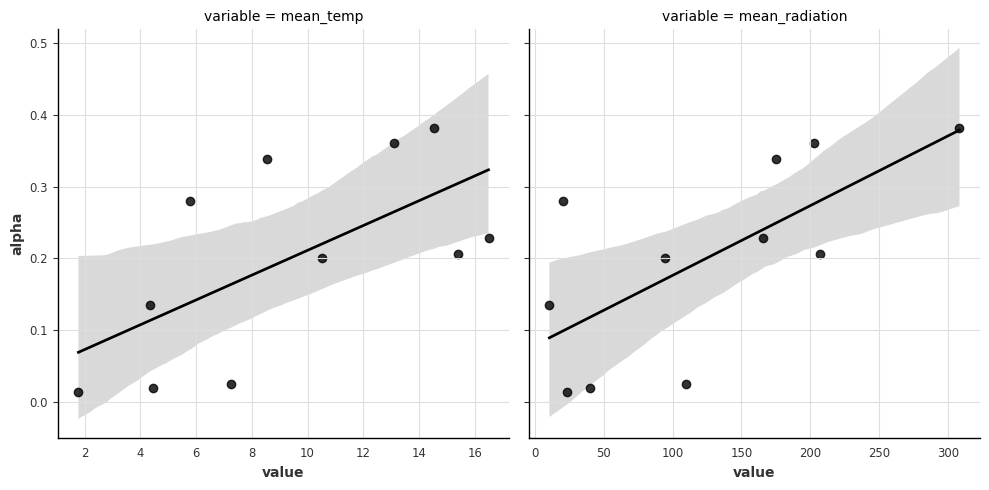

In [ ]:
datplot = pd.DataFrame(results, columns=["alpha", "mean_temp", "mean_radiation"]).melt(
    id_vars="alpha"
)
sns.lmplot(
    datplot, x="value", y="alpha", col="variable", order=1, facet_kws=dict(sharex=False)
);

### Visualization

In [ ]:
def plot_timeseries_by_unit(data):
    with open("./units.json", "r") as f:
        units = json.load(f)

    dfmelt = data.melt(ignore_index=False)
    dfmelt["unit"] = dfmelt["component"].map(units)

    sns.relplot(
        dfmelt.reset_index(),
        x="time",
        y="value",
        row="unit",
        kind="line",
        hue="component",
        facet_kws=dict(sharey=False),
        aspect=5,
    )

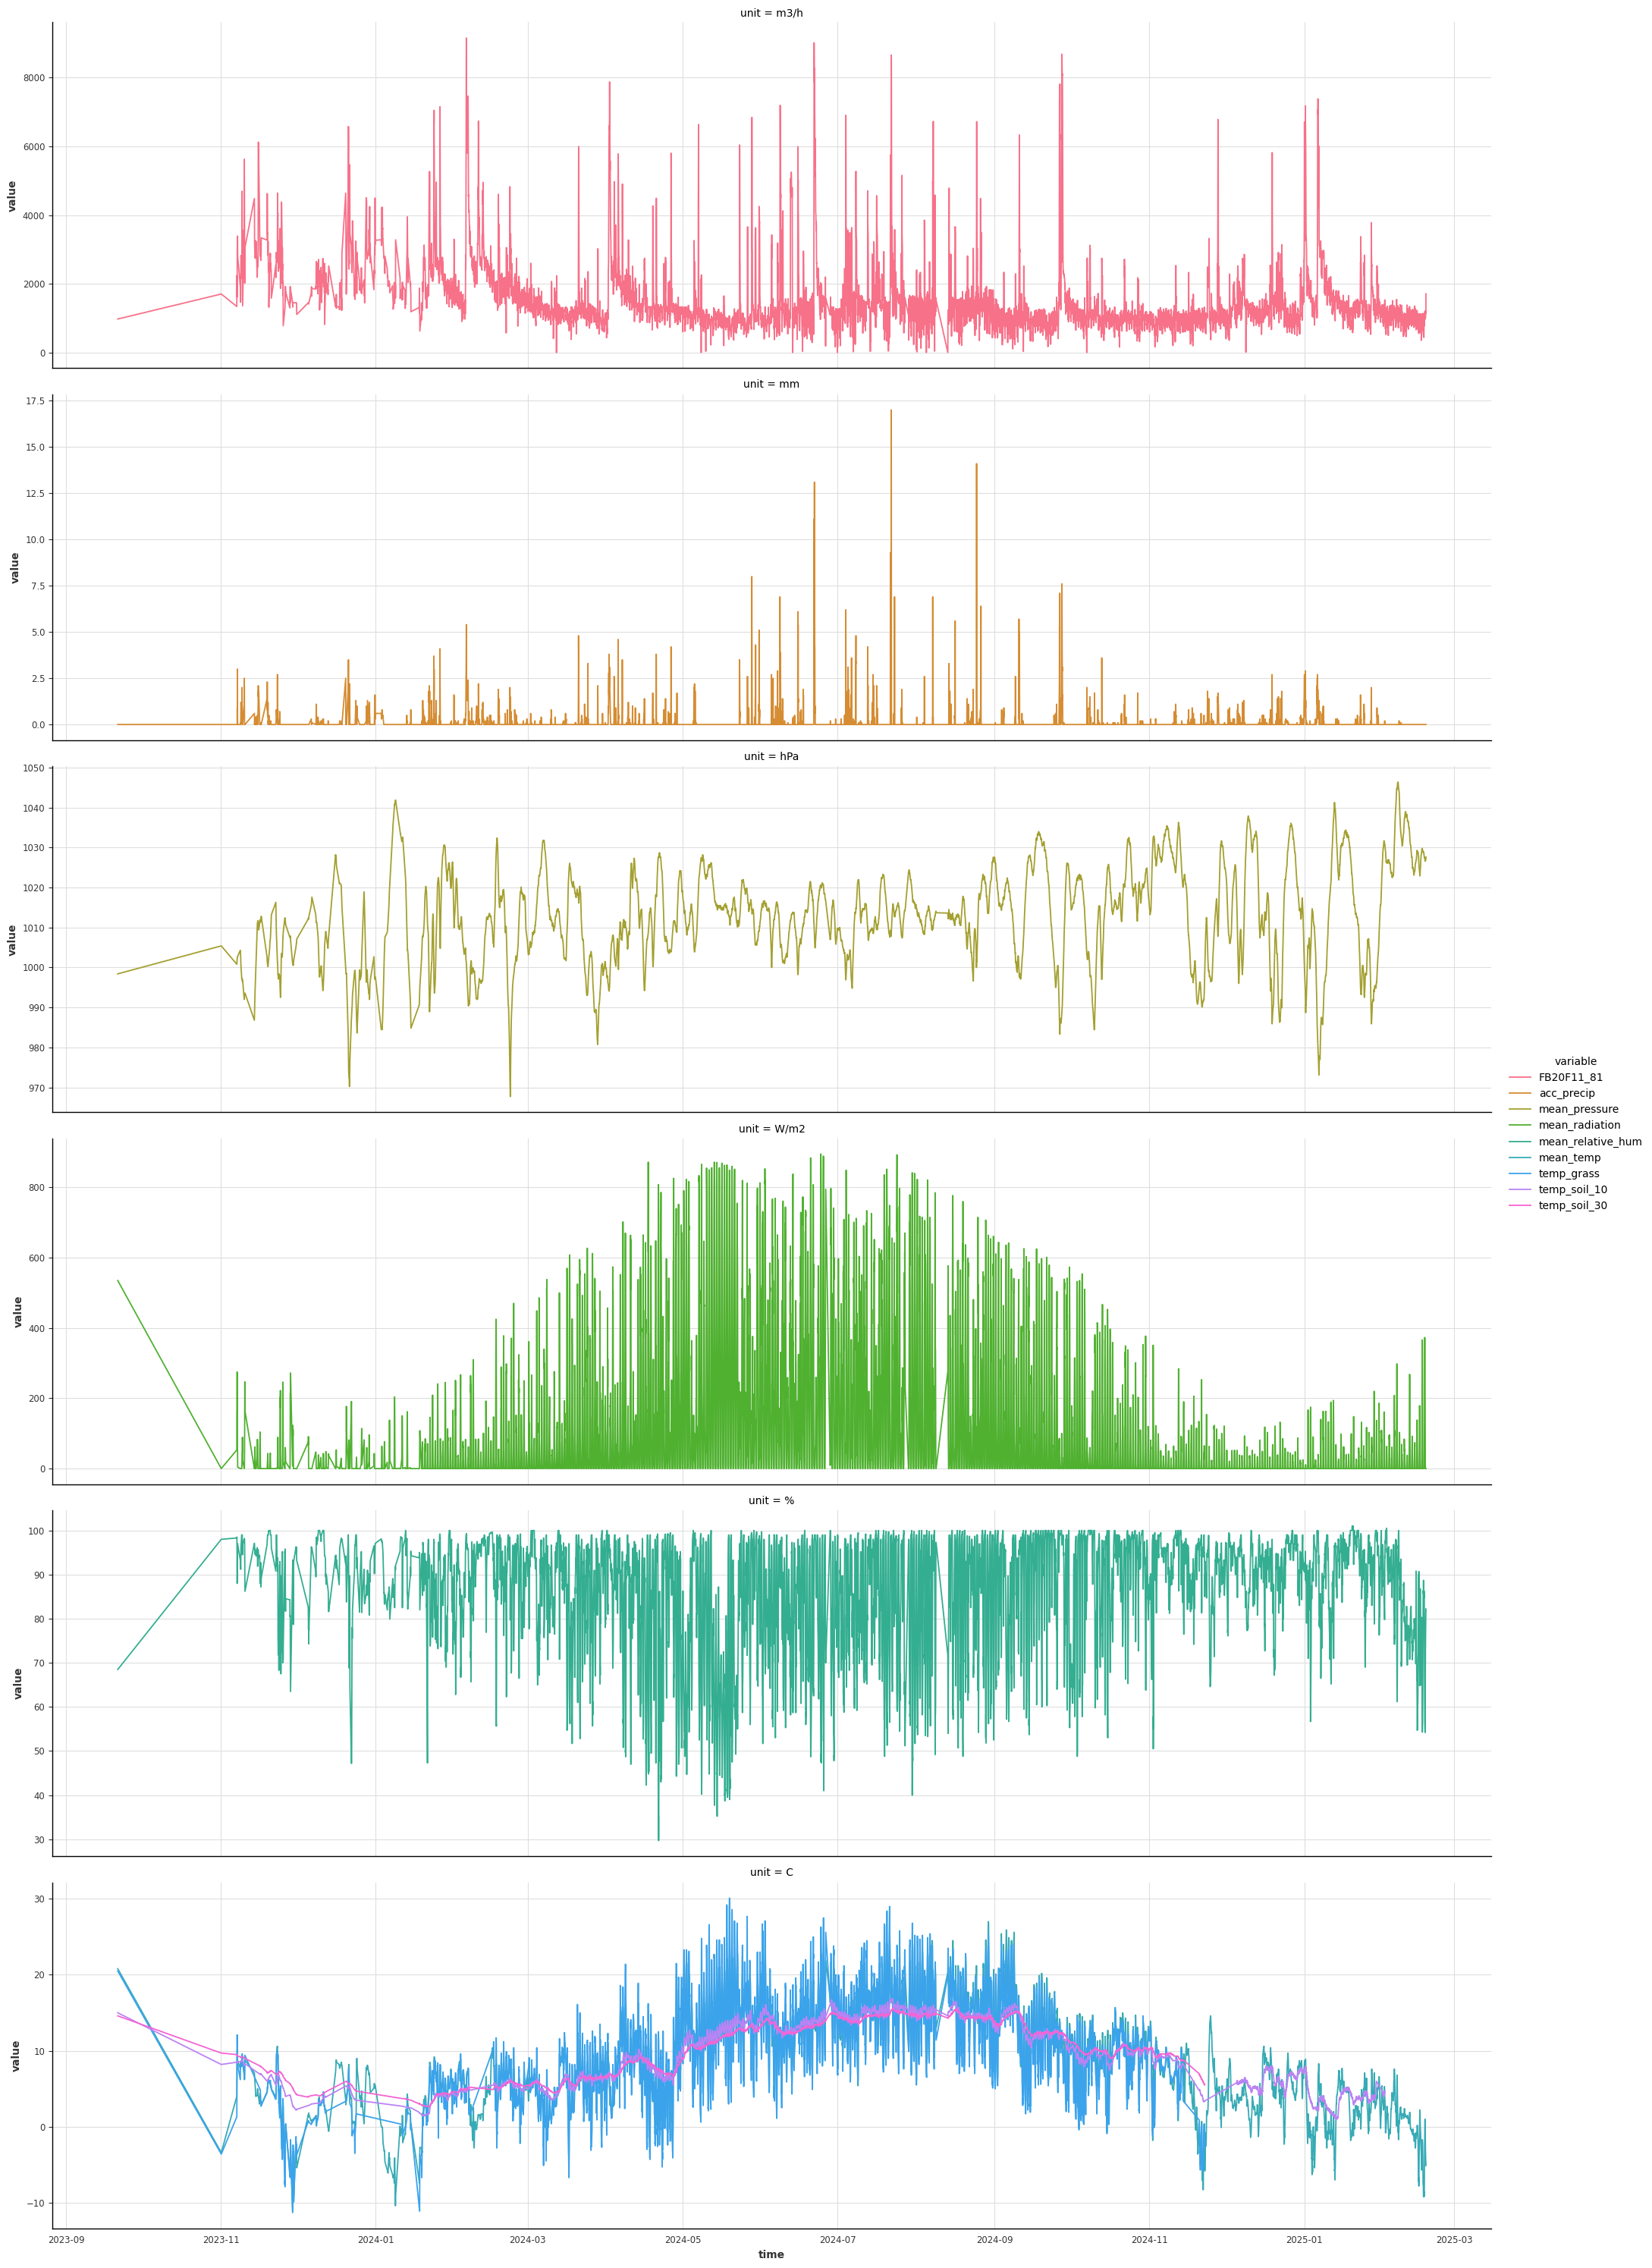

In [ ]:
plot_timeseries_by_unit(ts.pd_dataframe())